In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
import nltk

%matplotlib inline

sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
df=pd.read_csv('./datasets/df.csv')

In [3]:
df.sample(5)

,job_id,company,title,location,employment_type,level,category,salary_min,category.1,salary_max,salary_time,exp,date_close,clean_role,clean_req,skills,url,date_scrape
1907,JOB-2019-0069126,Company Undisclosed,Section Manager Supply Chain (73502),"FRONTIER, 50 UBI AVENUE 3 408866","Permanent, Full Time",Manager,Logistics / Supply Chain,"$4,800",Logistics / Supply Chain,"$6,900",Monthly,3 years exp,Closing on 02 May 2019,Job Responsibilities: Management of Projects a...,"Requirements Minimum Diploma, preferably Degre...","Continuous Improvement,Cross-functional Team L...",https://www.mycareersfuture.sg/job/section-man...,01-05-2019
1819,JOB-2018-0234335,STYLETHEORY PRIVATE LIMITED,Operations Head,"HAIG COURT, 152 HAIG ROAD 438791","Permanent, Full Time","Senior Management, Manager","Logistics / Supply Chain, General Management","$8,000","Logistics / Supply Chain, General Management","$12,000",Monthly,3 years exp,Closing on 04 May 2019,Company Overview: Style Theory is a Fashion-Te...,Requirements Requirements: Have worked in a re...,"5S,BPO,Budgets,Continuous Improvement,Contract...",https://www.mycareersfuture.sg/job/operations-...,01-05-2019
1576,JOB-2019-0078587,NTUC ENTERPRISE CO-OPERATIVE LTD,"Vice President, Enterprise Data Warehouse",21 LOWER KENT RIDGE ROAD 119077,Full Time,Middle Management,"Education and Training, Information Technology","$8,000","Education and Training, Information Technology","$13,000",Monthly,5 years exp,Closing on 12 May 2019,COMPANY DESCRIPTION NTUC Enterprise is the hol...,Requirements Must be highly technical/strong h...,"Business Analysis,Business Intelligence,Data A...",https://www.mycareersfuture.sg/job/vice-presid...,01-05-2019
1060,JOB-2019-0090362,NANYANG TECHNOLOGICAL UNIVERSITY,Project Officer,"NANYANG TECHNOLOGICAL UNIVERSITY, 50 NANYANG A...","Contract, Full Time",Professional,"Engineering, Sciences / Laboratory / R&D","$3,400","Engineering, Sciences / Laboratory / R&D","$4,400",Monthly,10 years exp,Closing on 28 May 2019,The Rapid-Rich Object SEarch (ROSE) Lab is a j...,Requirements Bachelor degree in Computer Scien...,"Algorithms,Artificial Intelligence,C,C++,Compu...",https://www.mycareersfuture.sg/job/project-off...,01-05-2019
710,JOB-2019-0085815,KELLY SERVICES (SINGAPORE) PTE. LTD.,Programme Coordinator,"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Executive,Information Technology,"$5,000",Information Technology,"$7,000",Monthly,6 years exp,Closing on 23 May 2019,We are looking for an exceptional Program Coor...,Requirements Minimum 2 years of programme/proj...,"Community Outreach,Customer Service,Editing,Ev...",https://www.mycareersfuture.sg/job/programme-c...,01-05-2019


In [4]:
#check for number of null values after scraping
df.isnull().sum()

job_id               0
company              0
title                0
location             0
employment_type      0
level                0
category             0
salary_min           0
category.1           0
salary_max           0
salary_time          0
exp                  0
date_close           0
clean_role          74
clean_req          252
skills              74
url                  0
date_scrape          0
dtype: int64

In [5]:
#check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 18 columns):
job_id             2234 non-null object
company            2234 non-null object
title              2234 non-null object
location           2234 non-null object
employment_type    2234 non-null object
level              2234 non-null object
category           2234 non-null object
salary_min         2234 non-null object
category.1         2234 non-null object
salary_max         2234 non-null object
salary_time        2234 non-null object
exp                2234 non-null object
date_close         2234 non-null object
clean_role         2160 non-null object
clean_req          1982 non-null object
skills             2160 non-null object
url                2234 non-null object
date_scrape        2234 non-null object
dtypes: object(18)
memory usage: 314.2+ KB


In [6]:
#check number of rows and columns
df.shape

(2234, 18)

In [7]:
#drop duplicates with the same job_id
df.drop_duplicates(subset ="job_id", keep = False, inplace=True) 
df.shape

(1339, 18)

In [8]:
#drop columns that are definitely not required
useless = ['job_id','date_close','url','date_scrape']
df.drop(columns=useless,inplace=True)
df.shape

(1339, 14)

## Column : Title 

In [9]:
#start to clean for title column
#perform lowercase 
    
df['title']=df.title.str.lower()

In [10]:
#function to manually classify the data job titles

def clean_title(x):  
    
    if 'vp' in x:
        return 'management'
    
    elif 'data analyst' in x:
        if 'senior data analyst' in x or 'senior analyst' in x or 'senior analytics' in x or 'lead' in x:
            return 'data scientist'     
        else:
            return 'data analyst'
        
    elif 'data scientist' in x or 'machine' in x or 'deep' in x or 'algorithm' in x:
        return 'data scientist'
    
    elif 'research' in x or 'robotic' in x or 'consultant' in x or 'image' in x or 'nlp' in x or 'language' in x or 'ai' in x:
        return 'data scientist'
  
    elif 'architect' in x or 'engineer' in x:
        return 'data engineer'

    elif 'business analyst' in x:
        if 'senior business analyst' in x:
            return 'data scientist'
        else:
            return 'business analyst'
   
    elif 'software' in x or 'business system analyst' in x:
        return 'software engineer'
    
    elif 'recruitment' in x:
        return np.nan
    
    else: 
        return np.nan

In [11]:
#final categorization done
df['title_clean']=df.title.map(clean_title)
df.title_clean.value_counts()

data scientist       278
business analyst     167
data engineer        149
management            55
software engineer     26
data analyst          20
Name: title_clean, dtype: int64

In [12]:
df.title_clean.isnull().sum()

644

In [13]:
#drop job titles that are not useful(np.nan) at all
df.dropna(subset = ['title_clean'],inplace=True)
df.shape

(695, 15)

## Column = employment_type

In [14]:
df.employment_type.unique()

array(['Contract', 'Full Time', 'Permanent', 'Permanent, Full Time',
       'Permanent, Contract', 'Contract, Full Time',
       'Part Time, Permanent, Temporary, Freelance, Full Time, Internship',
       'Permanent, Contract, Full Time', 'Part Time, Contract',
       'Full Time, Internship', 'Temporary',
       'Part Time, Permanent, Full Time', 'Temporary, Contract'],
      dtype=object)

In [15]:
#start to clean for employment_type column
#perform lowercase 
df['employment_type']=df.employment_type.str.lower()

In [16]:
df.employment_type.unique()

array(['contract', 'full time', 'permanent', 'permanent, full time',
       'permanent, contract', 'contract, full time',
       'part time, permanent, temporary, freelance, full time, internship',
       'permanent, contract, full time', 'part time, contract',
       'full time, internship', 'temporary',
       'part time, permanent, full time', 'temporary, contract'],
      dtype=object)

In [17]:
#function to manually classify the employment_type

def clean_employ(x):
    
    if x=='permanent, full time' or x=='full time' or x=='permanent':
        return 'permanent'
    
    elif x=='permanent, contract' or x=='temporary, contract' or x=='permanent, contract, full time':
        return 'contract'

    elif x=='part time, permanent, temporary, freelance, full time, internship' or x=='part time, permanent, full time':
        return 'permanent'
    
    elif x=='permanent, contract' or x=='part time, contract' or x=='contract, full time':
        return 'contract'
    
    elif x=='full time, internship':
        return 'permanent'
    
    elif x=='temporary':
        return 'temporary'
    
    elif x=='internship':
        return 'internship'

    else: 
        return x

In [18]:
df['employment_type']=df.employment_type.map(clean_employ)
df.employment_type.value_counts()

permanent    522
contract     172
temporary      1
Name: employment_type, dtype: int64

## Column = exp

In [19]:
df.exp.unique()

array(['3 years  exp', '4 years  exp', '7 years  exp', '8 years  exp',
       '5 years  exp', '1 year  exp', '10 years  exp', '9 years  exp',
       '6 years  exp', '2 years  exp', '12 years  exp', '15 years  exp'],
      dtype=object)

In [20]:
#retain only numbers
df['exp']=df.exp.str.findall(pat='(\d+)')

In [21]:
#use only the first element
df['exp']=df.exp.apply(lambda x: x[0])

In [22]:
#change to int
df['exp']=pd.to_numeric(df.exp)

In [23]:
#cleaned
df.exp[:5]

1     3
4     3
5     4
6     3
10    7
Name: exp, dtype: int64

## Column = salary_min, salary_max, salary_time

In [24]:
#remove '$',',' so that it can be converted to numeric
df['salary_min']=df.salary_min.str.replace('$','').str.replace(',','')
df['salary_max']=df.salary_max.str.replace('$','').str.replace(',','')

#need to use apply method to impute np.nan
df['salary_min']=df.salary_min.apply(lambda x : np.nan if x=='Salary undisclosed' else x)

#convert to to int columns else we can't perform maths operation
df['salary_max']=df.salary_max.astype('int64')
df['salary_min']=pd.to_numeric(df.salary_min)

In [25]:
#df.salary_max divide by 12 for those that are annual

def clean_max_sal(x):
    if x['salary_time']=='Annually':
        return x['salary_max']/12
    else:
        return x['salary_max']

df['salary_max']=df.apply(clean_max_sal,axis=1)

In [26]:
#df.salary_min divide by 12 for those that are annual

def clean_min_sal(x):
    if x['salary_time']=='Annually':
        return x['salary_min']/12
    else:
        return x['salary_min']

df['salary_min']=df.apply(clean_min_sal,axis=1)

In [27]:
#impute df.salary_min that is undisclosed using a median ratio of min/max
ratio = df.salary_min.median()/df.salary_max.median()
df.loc[df.salary_min.isnull(),'salary_min']=df.salary_max*ratio

In [28]:
#feature engineering as mean of a salary range might provide a better indication as sometimes the range is too wide
df['salary_mean']=(df['salary_max'] + df['salary_min']) /2

In [29]:
#dropping both of them as they are not required
#salary_min is considered as freshies would look at the min salary rather than max salary
df.drop(columns=['salary_max','salary_time','salary_min'],inplace=True)

## Column = level

In [30]:
df.level.unique()

array(['Executive', 'Professional', 'Senior Executive',
       'Junior Executive', 'Professional, Executive, Senior Executive',
       'Non-executive', 'Manager', 'Fresh/entry level',
       'Professional, Executive', 'Middle Management',
       'Executive, Senior Executive', 'Senior Management',
       'Manager, Professional, Senior Executive',
       'Professional, Senior Executive', 'Middle Management, Manager',
       'Junior Executive, Senior Executive',
       'Middle Management, Professional',
       'Middle Management, Senior Executive',
       'Executive, Junior Executive',
       'Fresh/entry level, Executive, Non-executive',
       'Senior Management, Manager', 'Professional, Junior Executive',
       'Manager, Fresh/entry level, Professional', 'Manager, Executive',
       'Fresh/entry level, Junior Executive, Senior Executive',
       'Fresh/entry level, Executive, Junior Executive',
       'Professional, Non-executive',
       'Manager, Fresh/entry level, Senior Executive'

In [31]:
#this level column is very haphazard
#if you look at the extreme ends senior exective can be 2 years exp
#fresh/entry level can be 8 years exp
#from here, I think using exp is better than to use this column as an input

df.groupby('level')['exp'].median().sort_values()

level
Executive                                                 2.0
Middle Management, Manager                                2.0
Middle Management, Manager, Senior Executive              2.0
Middle Management, Senior Executive                       2.0
Junior Executive, Senior Executive                        2.0
Junior Executive                                          2.0
Professional, Junior Executive                            2.0
Professional, Executive, Senior Executive                 2.0
Professional, Non-executive                               2.0
Professional, Senior Executive                            2.0
Senior Executive                                          2.0
Fresh/entry level, Executive, Non-executive               2.0
Manager, Professional, Senior Executive                   2.0
Senior Management, Manager                                2.5
Senior Management, Middle Management                      3.0
Professional                                              3.0
Se

In [32]:
#drop level column
df.drop(columns=['level'],inplace=True)

## Column = category

In [33]:
#drop duplicate columns
df.drop(['category.1'],axis=1,inplace=True)

In [34]:
def clean_category(x):      
    
    if 'Banking' in x :
        return 'Banking'
    elif 'R&D' in x : 
        return 'R&D'
    elif 'Civil Service' in x: 
        return 'Civil Service'
    elif 'Health' in x: 
        return 'Healthcare'
    elif 'Logistics' in x: 
        return 'Logistics'
    elif 'Engineering' in x: 
        return 'Engineering'
    elif 'Consulting' in x: 
        return 'Consulting'
    elif 'Marketing' in x: 
        return 'Marketing'
    elif 'Human Resource' in x: 
        return 'Human Resource'
    elif 'Professional Services' in x:
        return 'Professional Services'
    elif 'Accounting' in x:
        return 'Accounting'
    elif 'Others' in x or 'General Management' in x :
        return 'Others'
    elif 'Design' in x:
        return 'Design'
    elif 'Travel ' in x:
        return 'Travel'
    elif 'Customer' in x:
        return 'Customer Service'
    else:
        return x
    
df['category_clean']=df.category.map(clean_category)
df.category_clean.value_counts()

Information Technology    301
Banking                   112
Engineering                62
R&D                        59
Consulting                 42
Civil Service              35
Others                     22
Education and Training     10
Advertising / Media         8
Logistics                   8
Design                      5
Human Resource              5
Professional Services       5
Accounting                  4
Healthcare                  3
Insurance                   3
Marketing                   3
Sales / Retail              2
Telecommunications          2
Admin / Secretarial         2
Customer Service            1
Travel                      1
Name: category_clean, dtype: int64

## Column = loc

In [35]:
#function to manually classify the data job titles

def clean_loc(x):  
    
    if 'RAFFLES' in x or 'MARINA' in x or 'ROBINSON' in x or 'SHENTON' in x or 'ANSON' in x or 'CIRCULAR' in x:
        return 'CENTRAL'
    
    elif 'SUNTEC' in x or 'SHORT STREET' in x or 'MARKET STREET' in x or 'HOSPITAL' in x or 'WALLICH' in x: 
        return 'CENTRAL'
    
    elif 'BATTERY' in x or 'SHORT STREET' in x or 'KEPPEL' in x or 'BAYFRONT' in x or 'CROSS STREET' in x: 
        return 'CENTRAL'
    
    elif 'CECIL' in x or 'SCOTTS' in x or 'CHULIA' in x or 'HIGH STREET' in x or 'COLEMAN' in x or 'FINANCIAL' in x: 
        return 'CENTRAL'
    
    elif 'PHILLIP' in x or 'COLLYER' in x or 'EXETER' in x or 'ORCHARD' in x or 'CHURCH' in x or 'BRAS' in x:
        return 'CENTRAL'
    
    elif 'SOMERSET' in x or 'TEMASEK' in x or 'CARPENTER' in x or 'CLEMENCEAU' in x or 'TRAS' in x or 'MAGAZINE' in x:
        return 'CENTRAL'
    
    elif 'IRRAWADDY' in x or 'PICKERING' in x or 'NEWTON' in x or 'ANTHONY' in x or 'CHIN SWEE' in x or 'TANGLIN' in x: 
        return 'CENTRAL'
    
    elif 'NANYANG TECH' in x or 'MAPLETREE' in x or 'KENT' in x or 'AYER RAJAH' in x or 'SCIENCE PARK' in x:
        return 'WEST'

    elif 'TEMPLE' in x or 'CANTONMENT' in x or 'GERMAN CENTRE' in x or 'HOSPITAL' in x or 'FUSIONOPOLIS' in x:
        return 'WEST'
    
    elif 'TEMPLE' in x or 'BEACH' in x or 'HAVELOCK' in x or 'AYER RAJAH' in x or 'SCIENCE PARK' in x or 'JURONG' in x:
        return 'WEST'

    elif 'CREATE' in x or 'BESAR' in x or 'PANDAN' in x or 'BATOK' in x or 'VENTURE' in x or 'DEPOT' in x or 'BUROH' in x:
        return 'WEST'
    
    elif 'NORTH BRIDGE' in x or 'NEW BRIDGE' in x or 'TIMAH' in x or 'PIONEER' in x or 'LENG KEE' in x or 'HENDERSON' in x:
        return 'WEST'
    
    elif 'ALEXANDRA' in x or 'BUKIT MERAH' in x or 'SYNERGY' in x or 'NEIL' in x or 'VENTURE' in x or 'BALESTIER' in x:
        return 'WEST'
    
    elif 'PRESTON' in x or 'TELOK AYER' in x or 'WEST' in x or 'COMMONWEALTH' in x or 'KLING' in x or 'BALESTIER' in x:
        return 'WEST'
    
    elif 'STRATEGY' in x:
        return 'WEST'
    
    elif 'CHANGI' in x or 'PAYA LEBAR' in x or 'KALLANG' in x or 'UBI' in x or 'BENDEMEER' in x  or 'AIRLINE' in x:
        return 'EAST'
    
    elif 'BENCOOLEN' in x or 'RIS' in x or 'MIDDLE' in x or 'ALJUNIED' in x or 'LAVENDER' in x or 'AIRLINE' in x:
        return 'EAST'
    
    elif 'RIS' in x or 'PAYA LEBAR' in x or 'KALLANG' in x or 'UBI' in x or 'HUDSON' in x  or 'EXPO' in x:
        return 'EAST'
    
    elif 'TAI SENG' in x or 'WILKIE' in x or 'TAMPINES' in x or 'HOWARD' in x or 'BURN' in x:
        return 'EAST'
    
    elif 'WATERLOO' in x or 'BUSSORAH' in x or 'CHAI CHEE' in x:
        return 'EAST'
    
    elif 'ANG MO KIO' in x or 'WOODLANDS' in x or 'CHUAN' in x or 'THOMSON' in x or 'PEMIMPIN' in x or 'SIN MING' in x:
        return 'NORTH'
  
    elif 'TANNERY' in x or 'SELETAR' in x or 'TOA PAYOH' in x or 'SENOKO' in x or 'JOAN' in x:
        return 'NORTH'    
    else: 
        return x
    
df['loc_clean']=df.location.apply(clean_loc)


# EDA

In [36]:
#we will EDA based on data science related roles
df_eda=df[(df.title_clean!='software engineer') & (df.title_clean!='management')]

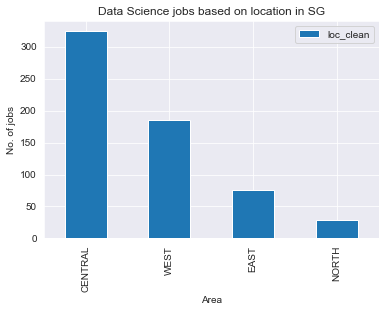

In [37]:
#Most data science jobs are avaiable in the central,followed by west
df_eda.loc_clean.value_counts().to_frame().plot(kind='bar');
plt.title('Data Science jobs based on location in SG')
plt.xlabel('Area')
plt.ylabel('No. of jobs');

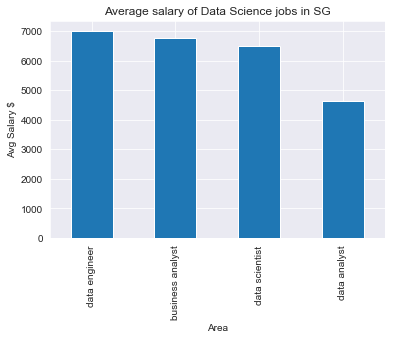

In [38]:
# Data Engineer has the highest salary at $7,000
# followed by business analyst at $6,700
# Data Scientist at $6,500
# and lastly data analyst at $4,500

df_eda.groupby(['title_clean'])['salary_mean'].median().sort_values(ascending=False).plot(kind='bar');
plt.title('Average salary of Data Science jobs in SG')
plt.xlabel('Area')
plt.ylabel('Avg Salary $');

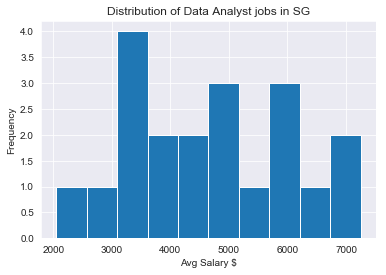

In [39]:
#It's slightly skewed to right for Data Analyst
#It could be due to HR misclassify some of the Data Analyst jobs as Data Scientist
# Median pay is around $3,500

df_eda[df_eda.title_clean=='data analyst']['salary_mean'].plot(kind='hist')
plt.title('Distribution of Data Analyst jobs in SG')
plt.ylabel('Frequency')
plt.xlabel('Avg Salary $');

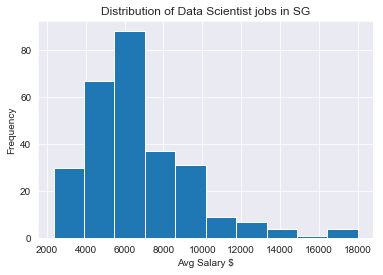

In [40]:
#It's skewed to the right for Data Scientist
# Median pay is around $6,000

df_eda[df_eda.title_clean=='data scientist']['salary_mean'].plot(kind='hist')
plt.title('Distribution of Data Scientist jobs in SG')
plt.ylabel('Frequency')
plt.xlabel('Avg Salary $');

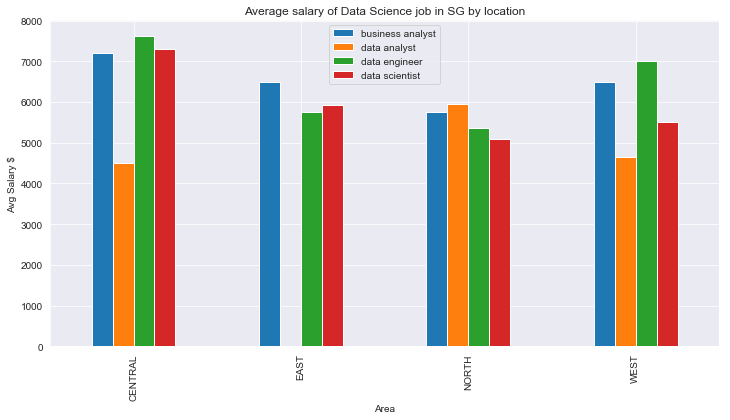

In [41]:
#highest for data scientist is Central followed by East and West
#highest for data analyst is in the North followed by West and Central
#data scientist are paid highest in central
#data analyst are paid highest in north

df_eda.groupby(['loc_clean','title_clean'])['salary_mean'].median().unstack(1).plot(kind='bar',figsize=(12, 6))
plt.title('Average salary of Data Science job in SG by location')
plt.xlabel('Area')
plt.ylabel('Avg Salary $')
plt.legend(loc='best');

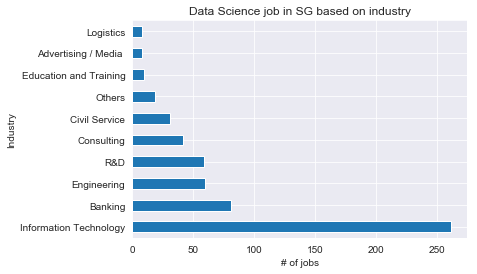

In [42]:
# IT requires data science the most, followed by banks, engineering, R&D , consulting

df_eda['category_clean'].value_counts()[:10].plot(kind='barh')
plt.title('Data Science job in SG based on industry')
plt.xlabel('# of jobs')
plt.ylabel('Industry');

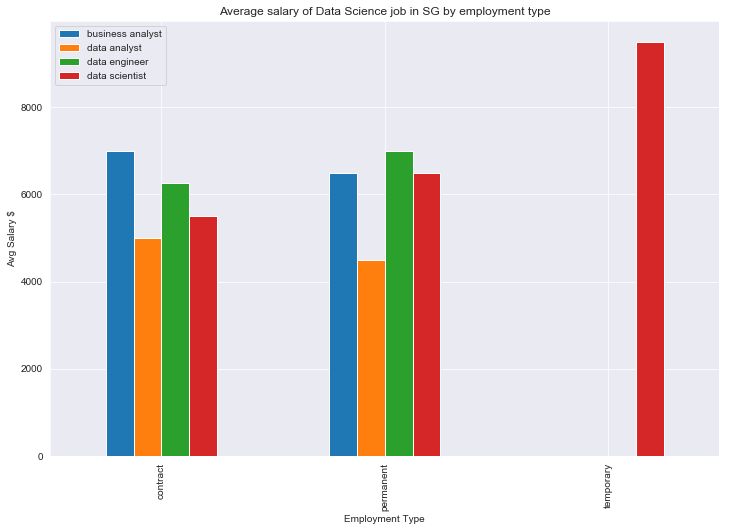

In [43]:
#for contract , business and data analyst is higher
#for permanent , data engineer and data scientist is higher 

df_eda.groupby(['employment_type','title_clean'])['salary_mean'].median().unstack(1).plot(kind='bar',figsize=(12, 8))
plt.title('Average salary of Data Science job in SG by employment type')
plt.xlabel('Employment Type')
plt.ylabel('Avg Salary $')
plt.legend(loc='best');

In [44]:
# the outlier of the temporary job is high is because it's a data scientist ( temporary consultant job)
df_eda[df_eda.employment_type=='temporary']

,company,title,location,employment_type,category,exp,clean_role,clean_req,skills,title_clean,salary_mean,category_clean,loc_clean
1425,AD ASTRA CONSULTANTS PRIVATE LTD.,research analyst,"THE OCTAGON, 105 CECIL STREET 069534",temporary,Sales / Retail,5,5+ years experience in Market Research or cons...,Requirements Experience working in retail/ con...,"Algorithms,Biochemistry,Biotechnology,C++,Cell...",data scientist,9506.25,Sales / Retail,CENTRAL


In [45]:
#the exp is moderately corelatted to salary_mean
df_eda.corr()

,exp,salary_mean
exp,1.000000,0.049161
salary_mean,0.049161,1.000000


# Modelling

In [46]:
#remove some of the default text before combining

df_eda['clean_role']=df_eda.clean_role.str.replace('roles responsibilities','').str.lower()
df_eda['clean_req']=df_eda.clean_req.str.replace('requirements','').str.lower()

#combine all the job descriptions, roles and skills for nlp
df_eda['nlp']=df_eda['clean_role']+df_eda['clean_req']+df_eda['skills']

In [47]:
non_nlp=['employment_type','category_clean','loc_clean','title_clean','exp']
df_eda[non_nlp].shape

(614, 5)

In [48]:
#re-create new df for ML
require =['employment_type','exp','nlp','title_clean', 
          'salary_mean','category_clean', 'loc_clean']
ml=df_eda[require]

In [49]:
#to prepare for classification
#encode 1 if more than median salary else 0

ml['y']=ml.salary_mean.apply(lambda x : 1 if x > ml.salary_mean.median() else 0)

#fillna with 0 so that CountVectorizer can be done
ml.fillna(0,inplace=True)
ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 1 to 2223
Data columns (total 8 columns):
employment_type    614 non-null object
exp                614 non-null int64
nlp                614 non-null object
title_clean        614 non-null object
salary_mean        614 non-null float64
category_clean     614 non-null object
loc_clean          614 non-null object
y                  614 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 43.2+ KB


In [50]:
#text preprocessing
lemma = nltk.wordnet.WordNetLemmatizer()
ml['nlp'] = ml['nlp'].apply(lambda x : str(x))
ml['nlp'] = ml['nlp'].apply(lambda x : re.sub('\W+',' ', x).lower()) #remove punctuations and lower text
ml['nlp'] = ml['nlp'].apply(lambda x: " ".join(x.split())) #remove additional spaces
ml['nlp'] = ml['nlp'].apply(lambda x: lemma.lemmatize(x)) #lemmatize


In [51]:
#sample of processed text
ml.nlp.values[2]

'frontline team members who have to mix solid understanding of the business goals and directions with a wide range of technical skills produce detailed analysis for business immersed in the data on a day to day basis provide best insights into data quality and spark some of the best new ideas report on data quality skilled in a wide range of data modeling and data analytic tools experienced in etl and have a working knowledge of the big data ecosystem tool tableu power birequirements frontline team members who have to mix solid understanding of the business goals and directions with a wide range of technical skills produce detailed analysis for business immersed in the data on a day to day basis provide best insights into data quality and spark some of the best new ideas report on data quality skilled in a wide range of data modeling and data analytic tools experienced in etl and have a working knowledge of the big data ecosystem tool tableau power biactive directory cisco technologies

In [52]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['http', 'https', 'rt']

In [53]:
# So .. we'll use np.sum() to convert it directly from the sparse matrix!
# This is enormously more memory-efficient ...
#   It only requires one int per column since summing across columns is the total word count.

def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [54]:
#following are words that are most often used in the corpus
cvt      =  CountVectorizer(stop_words=stop, ngram_range=(1,2))
X_all    =  cvt.fit_transform(ml['nlp'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)

freq_words[:10]

business        3091
management      2372
data            2247
experience      1920
analysis        1446
requirements    1314
project         1232
team            1047
development      993
process          970
dtype: int64

In [55]:
#One Hot Encoding
OHE_1=pd.get_dummies(ml.employment_type,drop_first=True)
OHE_2=pd.get_dummies(ml.title_clean,drop_first=True)
OHE_3=pd.get_dummies(ml.category_clean,drop_first=True)
OHE_4=pd.get_dummies(ml.loc_clean,drop_first=True)

#drop columns that are dummied and concat back to original ml df
ml.drop(columns=['employment_type','title_clean','category_clean','loc_clean'],inplace=True)
ml=pd.concat([ml,OHE_1,OHE_2,OHE_3,OHE_4],axis=1)

# Question 1

In [56]:
#Calculate baseline
#we need to be better than this , (▀̿Ĺ̯▀̿ ̿) 
print('baseline : {}'.format((1-ml.y.sum()/len(ml.y)).round(2)))

baseline : 0.52


In [57]:
#reset index before modelling
ml.reset_index(inplace=True)
ml.drop(labels='index',inplace=True,axis=1)
ml.head()

,exp,nlp,salary_mean,y,permanent,temporary,data analyst,data engineer,data scientist,Admin / Secretarial,...,Marketing,Others,Professional Services,R&D,Sales / Retail,Telecommunications,Travel,EAST,NORTH,WEST
0,3,location outram salary up to 14 50 per hour re...,2050.00,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,sky premium international is looking for it ex...,3250.00,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,frontline team members who have to mix solid u...,6250.00,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,job description responsibilities provide strat...,6093.75,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,7,data analyst at traveloka is at the forefront ...,5950.00,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [58]:
# Use logistic regression for the first model to get a sense of what we can make out of
# inputs used are exp, dummified : employment_type, title, category,location

X=ml.drop(columns=['salary_mean','y','nlp'])
y=ml.y

lr = LogisticRegression()

print('cross val score : {}'.format(cross_val_score(lr, X, y, cv=5).mean().round(2)))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression: {}".format(lr.score(X_test,y_test).round(2)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))


cross val score : 0.63
Logistic Regression: 0.68
               precision    recall  f1-score   support

 lower salary       0.71      0.65      0.68        97
higher salary       0.65      0.70      0.67        88

    micro avg       0.68      0.68      0.68       185
    macro avg       0.68      0.68      0.68       185
 weighted avg       0.68      0.68      0.68       185

auc score : 0.68.


In [59]:
# Use Logistic Regression using the nlp columns ONLY
# nlp columns = column combination of role, requirement and skills 
X=ml.nlp
y=ml.y

#Transform X to TF-IDF
cvt = CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2)
X_cvt = cvt.fit_transform(X)
tfidf=TfidfTransformer()
X_tfidf=tfidf.fit_transform(X_cvt)
X_tfidf=X_tfidf.todense()
lr=LogisticRegression()

#cross validation
scores = cross_val_score(lr,X_tfidf, y, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.3,random_state=1,stratify=y)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression: {}".format(lr.score(X_test,y_test).round(3)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

cross-validation score: 0.67
Logistic Regression: 0.724
               precision    recall  f1-score   support

 lower salary       0.72      0.78      0.75        97
higher salary       0.73      0.66      0.69        88

    micro avg       0.72      0.72      0.72       185
    macro avg       0.73      0.72      0.72       185
 weighted avg       0.73      0.72      0.72       185

auc score : 0.72.


In [60]:
coef=pd.DataFrame(lr.coef_,columns=[cvt.get_feature_names()]).transpose()
coef.sort_values(by=0,ascending=False).head(10)

,0
architecture,0.869961
experience,0.755023
banking,0.719437
solutions,0.555327
enterprise,0.537744
lead,0.486621
management,0.435577
quantitative,0.427586
ability,0.418077
solution,0.388789


In [61]:
coef.sort_values(by=0,ascending=False).tail(10)

,0
university,-0.357640
campaign,-0.360017
school,-0.364460
network,-0.366660
diploma,-0.374336
needs,-0.416825
detection,-0.434993
sales,-0.438383
engineering,-0.445588
security,-0.453569


In [62]:
# Use Random Forests using the nlp columns ONLY

rf_nlp = RandomForestClassifier(n_estimators = 100, n_jobs = -1,random_state = 1)

#cross validation
scores = cross_val_score(rf_nlp,X_tfidf, y, cv=5,)
print('cross-validation score: {}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.3,random_state=1,stratify=y)
rf_nlp.fit(X_train,y_train)
y_pred = rf_nlp.predict(X_test)
print("Random Forest: {}".format(rf_nlp.score(X_test,y_test).round(3)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

cross-validation score: 0.67
Random Forest: 0.714
               precision    recall  f1-score   support

 lower salary       0.70      0.78      0.74        97
higher salary       0.73      0.64      0.68        88

    micro avg       0.71      0.71      0.71       185
    macro avg       0.72      0.71      0.71       185
 weighted avg       0.71      0.71      0.71       185

auc score : 0.71.


In [63]:
#Prepare df by combining relevant columns
# Use logistic regression on NLP and the the columns that we use at base ML

tfidf_pd=pd.DataFrame(X_tfidf,columns=cvt.get_feature_names())

#StandardScale the exp column to concat
ss=StandardScaler()
exp= df_eda['exp'].values
exp = np.array(exp).reshape(-1,1)
exp = ss.fit_transform(exp)
exp=pd.DataFrame(exp,columns=['exp'])

#sync the df index as some newly created df is not the same
tfidf_pd.index = OHE_1.index
exp.index = OHE_1.index

#concat all the columns
df_combined = pd.concat([exp,OHE_1,OHE_2,OHE_3,tfidf_pd],axis=1)


X=df_combined.values
y=ml.y

lr_combined=LogisticRegression()

#cross validation
scores = cross_val_score(lr,X, y, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
lr_combined.fit(X_train,y_train)
y_pred = lr_combined.predict(X_test)
print("Logistic Regression: {}".format(lr_combined.score(X_test,y_test).round(2)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

cross-validation score: 0.63
Logistic Regression: 0.68
               precision    recall  f1-score   support

 lower salary       0.71      0.64      0.67        97
higher salary       0.64      0.72      0.68        88

    micro avg       0.68      0.68      0.68       185
    macro avg       0.68      0.68      0.68       185
 weighted avg       0.68      0.68      0.68       185

auc score : 0.68.


In [64]:
# Use Naive Bayes on NLP and the the columns that we use at base ML

#MinMaxScaler the exp column to concat. MultinomialNB() doesn't accept -ve
mm=MinMaxScaler()
exp= df_eda['exp'].values
exp = np.array(exp).reshape(-1,1)
exp = mm.fit_transform(exp)
df_combined['exp']=exp

X=df_combined.values
y=ml.y

mnb = MultinomialNB()

#cross validation
scores = cross_val_score(mnb,X, y, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Naive bayes: {}".format(mnb.score(X_test,y_test).round(2)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

cross-validation score: 0.64
Naive bayes: 0.65
               precision    recall  f1-score   support

 lower salary       0.68      0.65      0.66        97
higher salary       0.63      0.66      0.64        88

    micro avg       0.65      0.65      0.65       185
    macro avg       0.65      0.65      0.65       185
 weighted avg       0.66      0.65      0.65       185

auc score : 0.65.


In [65]:
# Use Logistic Regression using the nlp columns + experience + employment_type
# nlp columns = column combination of role, requirement and skills and exp 
# OHE_1 ( employment_type)
# OHE_2 (title )

#StandardScale the exp column to concat
ss=StandardScaler()
exp= df_eda['exp'].values
exp = np.array(exp).reshape(-1,1)
exp = ss.fit_transform(exp)
exp=pd.DataFrame(exp,columns=['exp'])
tfidf_pd.index = tfidf_pd.index

df_exp_NLP = pd.concat([exp,OHE_1.reset_index(),tfidf_pd.reset_index()],axis=1)

X=df_exp_NLP.values
y=ml.y

lr_nlp_exp=LogisticRegression()

#cross validation
scores = cross_val_score(lr_nlp_exp,X, y, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.3,random_state=1,stratify=y)
lr_nlp_exp.fit(X_train,y_train)
y_pred = lr_nlp_exp.predict(X_test)
print("Logistic Regression: {}".format(lr_nlp_exp.score(X_test,y_test).round(3)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

cross-validation score: 0.63
Logistic Regression: 0.724
               precision    recall  f1-score   support

 lower salary       0.72      0.78      0.75        97
higher salary       0.73      0.66      0.69        88

    micro avg       0.72      0.72      0.72       185
    macro avg       0.73      0.72      0.72       185
 weighted avg       0.73      0.72      0.72       185

auc score : 0.72.


In [66]:
#####################################################
#                                                   #
# I have pickled the model at './datasets/rf_random'#
#                                                   #
####################################################

# Use RF on  all columns 
# using random grid search to optimize effiency

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [68]:
import pickle
rf_random = pickle.load(open('./datasets/rf_random', 'rb'))
#Obtain best estimator from Randomized SearchCV
best_grid=rf_random.best_estimator_
best_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
#Obtain best parameter for RF
best_params = rf_random.best_params_
best_params

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [70]:
#Best Score for RF
print(rf_random.best_score_.round(2)) 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
best_grid.fit(X_train,y_train)
y_pred = best_grid.predict(X_test)
print("Random Forest: {}".format(best_grid.score(X_test,y_test).round(2)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

0.69
Random Forest: 0.74
               precision    recall  f1-score   support

 lower salary       0.72      0.81      0.76        97
higher salary       0.76      0.65      0.70        88

    micro avg       0.74      0.74      0.74       185
    macro avg       0.74      0.73      0.73       185
 weighted avg       0.74      0.74      0.73       185

auc score : 0.73.


In [71]:
feature_importances = pd.DataFrame(best_grid.feature_importances_,
                                   index = df_exp_NLP.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)

,importance
experience,0.006549
statistics teaching,0.005611
lead,0.005494
stakeholders,0.005332
solutions,0.005204
change,0.005135
banking,0.005044
teams,0.004927
deliver,0.004833
products,0.004821


# Question 2a . Distinguish between Data Scientist and the rest

In [72]:
#re-create new df for ML2
require =['employment_type','exp','nlp','title_clean', 
          'salary_mean','category_clean', 'loc_clean']
ml=df_eda[require]

In [73]:
ml.title_clean.value_counts()

data scientist      278
business analyst    167
data engineer       149
data analyst         20
Name: title_clean, dtype: int64

In [74]:
#create new output, y=1 for data scientist, else 0
ml['y']=ml.title_clean.apply(lambda x : 1 if x=='data scientist' else 0)

#remove null values
ml=ml[~ml.nlp.isnull()].reset_index()


In [75]:
ml2=ml.drop('index',axis=1)
ml2.head(5)

,employment_type,exp,nlp,title_clean,salary_mean,category_clean,loc_clean,y
0,contract,3,location: outram salary: up to $14.50 per hour...,data analyst,2050.00,Admin / Secretarial,CENTRAL,0
1,permanent,3,sky premium international is looking for it ex...,data analyst,3250.00,Information Technology,CENTRAL,0
2,permanent,4,•frontline team members who have to mix solid ...,data analyst,6250.00,Engineering,CENTRAL,0
3,permanent,3,job description responsibilities provide strat...,data engineer,6093.75,Information Technology,EAST,0
4,permanent,7,data analyst at traveloka is at the forefront ...,data analyst,5950.00,Information Technology,NORTH,0


In [76]:
#baseline
1-(ml2.y.sum() / len(ml2)).round(2)

0.54

In [77]:
#One Hot Encoding
OHE_1=pd.get_dummies(ml.employment_type,drop_first=True)
OHE_2=pd.get_dummies(ml.title_clean,drop_first=True)
OHE_3=pd.get_dummies(ml.category_clean,drop_first=True)
OHE_4=pd.get_dummies(ml.loc_clean,drop_first=True)

#drop columns that are dummied and concat back to original ml df
ml2=ml.drop(columns=['employment_type','title_clean','category_clean','loc_clean'])

In [78]:
ml2=pd.concat([ml,OHE_1,OHE_2,OHE_3,OHE_4,],axis=1)

In [79]:
# Use logistic regression for first model to get some sense
X=ml2.loc[:,['exp','salary_mean']].values #.reshape(-1,1)
y=ml2.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(solver='lbfgs', max_iter=200)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('cross val score : {}'.format(cross_val_score(lr, X_train, y_train, cv=10).mean().round(2)))
print('-'*42, '\n')
print('confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-'*42, '\n')
print(classification_report(y_test, y_pred, target_names=['predict NOT Data_Scientist', 'predict Data_Scientist']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

cross val score : 0.64
------------------------------------------ 

confusion matrix
[[50 11]
 [24 32]]
------------------------------------------ 

                            precision    recall  f1-score   support

predict NOT Data_Scientist       0.68      0.82      0.74        61
    predict Data_Scientist       0.74      0.57      0.65        56

                 micro avg       0.70      0.70      0.70       117
                 macro avg       0.71      0.70      0.69       117
              weighted avg       0.71      0.70      0.70       117

auc score : 0.7.


In [80]:
# Use Random Forest using the nlp columns ONLY
# nlp columns = column combination of role, requirement and skills 
X=ml2.nlp
y=ml2.y

#Transform X to TF-IDF
cvt = CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2)
X_cvt = cvt.fit_transform(X)
tfidf=TfidfTransformer()
X_tfidf=tfidf.fit_transform(X_cvt)
X_tfidf=X_tfidf.todense()
rf=RandomForestClassifier()

#cross validation
scores = cross_val_score(lr,X_tfidf, y, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.3,random_state=1,stratify=y)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Random Forest: {}".format(rf.score(X_test,y_test).round(3)))

print(classification_report(y_test, y_pred, target_names=['lower salary', 'higher salary']))
print('auc score : {}.'.format(roc_auc_score(y_test, y_pred).round(2)))

pd.DataFrame(rf.feature_importances_,index=cvt.get_feature_names(),
             columns=['importance']).sort_values('importance',ascending=False).head(20)

cross-validation score: 0.75
Random Forest: 0.834
               precision    recall  f1-score   support

 lower salary       0.81      0.92      0.86        95
higher salary       0.88      0.74      0.80        80

    micro avg       0.83      0.83      0.83       175
    macro avg       0.84      0.83      0.83       175
 weighted avg       0.84      0.83      0.83       175

auc score : 0.83.


,importance
research science,0.035405
machine,0.032619
sdlc sql,0.019749
sql strategy,0.018729
business strategy,0.013813
requirements gathering,0.013366
requirements analysis,0.012514
phd,0.011021
business development,0.010226
cloud,0.009955


In [81]:
# We are selecting RF because of the high precision and high cross val score and also a higher AUC score as compared to 
# Logistic Regression. 
# some of the factors contributed are described above
# take note that RF's feature importance means we only know what is IMPORTANT and we do actually know if the feature is 
# contributing positively or not, as compared to Logistic Regression.

# Question 2b . Distinguish between Data Analyst and the rest

In [82]:
#create new output, y=1 for 'data analyst', else 0
#asi want to learn how to classify an imbalance class

#re-create new df for ML2
require =['employment_type','exp','nlp','title_clean', 
          'salary_mean','category_clean', 'loc_clean']
ml=df_eda[require]

#remove null values
ml=ml[~ml.nlp.isnull()].reset_index()
ml=ml.drop('index',axis=1)
ml.head(5)

,employment_type,exp,nlp,title_clean,salary_mean,category_clean,loc_clean
0,contract,3,location: outram salary: up to $14.50 per hour...,data analyst,2050.00,Admin / Secretarial,CENTRAL
1,permanent,3,sky premium international is looking for it ex...,data analyst,3250.00,Information Technology,CENTRAL
2,permanent,4,•frontline team members who have to mix solid ...,data analyst,6250.00,Engineering,CENTRAL
3,permanent,3,job description responsibilities provide strat...,data engineer,6093.75,Information Technology,EAST
4,permanent,7,data analyst at traveloka is at the forefront ...,data analyst,5950.00,Information Technology,NORTH


In [83]:
ml['y']=ml2.title_clean.apply(lambda x : 1 if x=='data analyst' else 0)
ml.head(5)

,employment_type,exp,nlp,title_clean,salary_mean,category_clean,loc_clean,y
0,contract,3,location: outram salary: up to $14.50 per hour...,data analyst,2050.00,Admin / Secretarial,CENTRAL,1
1,permanent,3,sky premium international is looking for it ex...,data analyst,3250.00,Information Technology,CENTRAL,1
2,permanent,4,•frontline team members who have to mix solid ...,data analyst,6250.00,Engineering,CENTRAL,1
3,permanent,3,job description responsibilities provide strat...,data engineer,6093.75,Information Technology,EAST,0
4,permanent,7,data analyst at traveloka is at the forefront ...,data analyst,5950.00,Information Technology,NORTH,1


In [84]:
#baseline
1-ml.y.sum() / len(ml) # imbalance dataset

0.9656946826758147

In [85]:
# Use MNB for first model to get some sense
X=ml.nlp
y=ml.y

#Transform X to TF-IDF
cvt = CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2)
X_cvt = cvt.fit_transform(X)
tfidf=TfidfTransformer()
X_tfidf=tfidf.fit_transform(X_cvt)
X_tfidf=X_tfidf.todense()
mnb=MultinomialNB()

#cross validation
scores = cross_val_score(mnb,X_tfidf, y, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),2), round(np.std(scores),2)))

X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.3,random_state=1,stratify=y)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("mnb: {}".format(mnb.score(X_test,y_test).round(3)))

print(classification_report(y_test, y_pred, target_names=['not_data_analyst', 'is_data_analyst']))

cross-validation score: 0.97
mnb: 0.966
                  precision    recall  f1-score   support

not_data_analyst       0.97      1.00      0.98       169
 is_data_analyst       0.00      0.00      0.00         6

       micro avg       0.97      0.97      0.97       175
       macro avg       0.48      0.50      0.49       175
    weighted avg       0.93      0.97      0.95       175



In [86]:
# Use logistic regression with smote up sampling
X=ml.nlp
y=ml.y

#Transform X to TF-IDF
cvt = CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2)
X_cvt = cvt.fit_transform(X)
tfidf=TfidfTransformer()
X_tfidf=tfidf.fit_transform(X_cvt)
X_tfidf=X_tfidf.todense()
lr_imb=LogisticRegression()

skf = StratifiedKFold(n_splits=5)
score = []

for train_index, test_index in skf.split(X_tfidf, y):
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
sm = SMOTE(ratio='minority',k_neighbors=13, random_state=240)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

In [87]:
lr_imb.fit(X_smote,y_smote)
smote_predict = lr_imb.predict(X_test)
smote_recall = recall_score(y_test, smote_predict)

print ("Upsample Test Score:", smote_recall.round(2))

print(classification_report(y_test, smote_predict, target_names=['not_data_analyst', 'is_data_analyst']))

Upsample Test Score: 0.5
                  precision    recall  f1-score   support

not_data_analyst       0.98      1.00      0.99       112
 is_data_analyst       1.00      0.50      0.67         4

       micro avg       0.98      0.98      0.98       116
       macro avg       0.99      0.75      0.83       116
    weighted avg       0.98      0.98      0.98       116



In [97]:
lr_imb.coef_.shape

(1, 24300)

In [99]:
len(cvt.get_feature_names())

24300

In [88]:
pd.DataFrame(lr_imb.coef_, columns=cvt.get_feature_names()).transpose().sort_values(by=0,ascending=False).head(20)

,0
data,3.347346
reports,1.941829
data analyst,1.870011
tableau,1.103690
data quality,1.096942
new reports,1.014660
excel,0.984012
scrum,0.983725
experience data,0.973175
insights,0.924028


In [100]:
lr_imb.coef_.sha

array([[-0.09753257, -0.0275227 , -0.01181001, ..., -0.00868685,
        -0.0048864 ,  0.        ]])

In [89]:
pd.DataFrame(lr_imb.coef_, columns=cvt.get_feature_names()).transpose().sort_values(by=0,ascending=False).tail(20)

,0
manage,-0.431910
solution,-0.442082
cloud,-0.454190
science,-0.467025
gathering,-0.467277
performance,-0.485089
process,-0.486626
functional,-0.490247
business,-0.500074
business process,-0.535130


In [90]:
ml.y.value_counts()

0    563
1     20
Name: y, dtype: int64

In [91]:
# Use RF with smote up sampling

rf=RandomForestClassifier()

rf.fit(X_smote,y_smote)
smote_predict = rf.predict(X_test)
smote_recall = recall_score(y_test, smote_predict)

print ("Upsample Test Score:", smote_recall.round(2))

print(classification_report(y_test, smote_predict, target_names=['not_data_analyst', 'is_data_analyst']))

Upsample Test Score: 0.0
                  precision    recall  f1-score   support

not_data_analyst       0.97      1.00      0.98       112
 is_data_analyst       0.00      0.00      0.00         4

       micro avg       0.97      0.97      0.97       116
       macro avg       0.48      0.50      0.49       116
    weighted avg       0.93      0.97      0.95       116



In [92]:
pd.DataFrame(rf.feature_importances_, index=cvt.get_feature_names()
             ,columns=['importance']).sort_values('importance',ascending=False).head(10)

,importance
integrity,0.074668
decisions,0.043688
databases,0.042578
data analyst,0.040336
provide,0.029474
details,0.025587
queries,0.022160
record,0.019081
analysis financial,0.017681
html,0.017391
